---

# Heat Equation

On the domain $x\in[-1,1]$, we wish to solve the heat equation,

$$u_t(x,t) = u_{xx}(x,t),$$

with Neumann boundary conditions,

$$u_x(-1,t)=1=u_x(1,t),$$

and initial condition 

$$u(x,t) = 1+\cos(\pi x)+0.2\cos(5\pi x).$$

In the limit as $t\to\infty$, the solution should be an affine function with slope 1.

We discretize space using a spectral Chebyshev collocation method of polynomial order $N$ onto a Chebyshev-Gauss-Lobatto grid, and integrate in time with a fourth order Runge-Kutta method.

Results with $N=32$
-------------------

In [1]:
%matplotlib inline
#from plt_style import *
import heatnb as heat

Running heat.py with numpy (CPU-MKL)


In [2]:
%%time
T,X,U,ctime,err = heat.main(32,[0,3],1e-4)

CPU times: user 907 ms, sys: 17.7 ms, total: 925 ms
Wall time: 917 ms


In [3]:
from hellaPy import *
import pylab as plt
import numpy as np


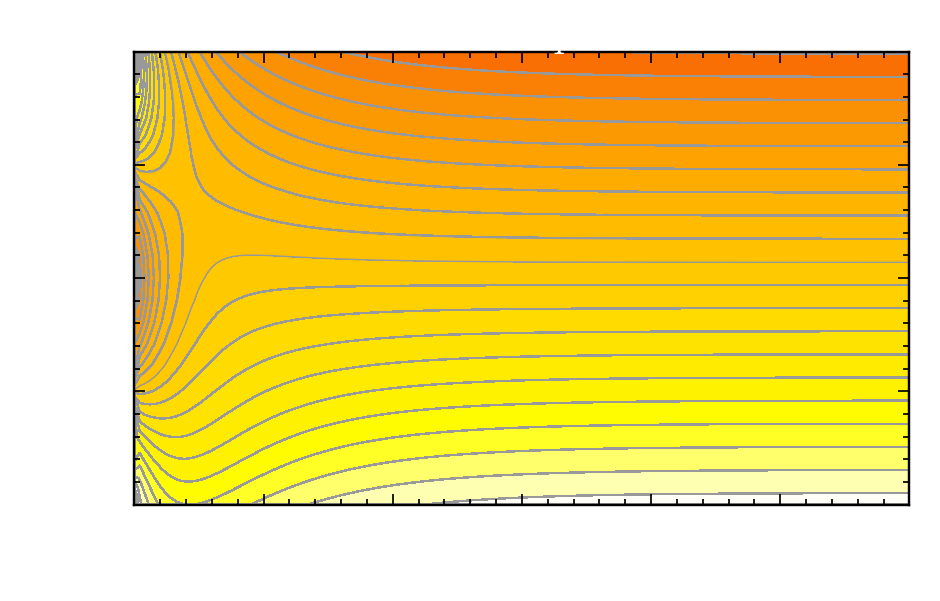

In [4]:
plt.figure(1,figsize=(10,6))
mycontourf(T,X,U,np.linspace(-1,1)*2.5,cmap=mycm15,edgecolor='#999999')
_=plt.xticks(fontsize=25,color='w')
_=plt.yticks(fontsize=25,color='w')
_=plt.xlabel('time',fontsize=30,color='w')
_=plt.ylabel('space',fontsize=30,color='w')
_=plt.title(f'Deviation from slope 1: {err:10.3e}',fontsize=36,color='w')

# What if there are many parameters that need to be explored?

In this example, suppose that we're interested in understanding the behavior of our heat equation with different flux conditions on the boundary. That is, suppose we want to set our Neumann boundary conditions to $k$ for $k=1,...,100$. 

Then we would need to run this same code 100 times, which is a daunting interactive task. 

Instead, since we have a working python script that we have debugged and understood within the notebook, we can now lean on the supercomputer's scheduler to submit all of the work for us. In fact, we'll see in this example that all 100 cases will start **simultaneously**.

In Jupyter notebooks, we can make calls to the shell with the exclaimation mark, `!`. Below we are printing the contents of our "job script" with the `cat` command, passing the `-n` flag to have it also print line numbers.

In [5]:
!cat -n job_submit.sh

     1	#!/bin/bash
     2	#SBATCH -p htc
     3	#SBATCH -q normal
     4	#SBATCH -t 5
     5	#SBATCH -c 2
     6	#SBATCH -o log/slurm.%A.%a.%j.out
     7	#SBATCH --array=1-100
     8	#SBATCH --export=NONE
     9	
    10	module load anaconda/py3
    11	source activate pyintel
    12	
    13	python heatnb.py $SLURM_ARRAY_TASK_ID


The above job script essentially tells the scheduler what resources are necessary for the job to run (lines prefixed with `#SBATCH`). The very first line, called a "shell bang" line, specifies the path to the program that will be running the actual script commands on lines 10, 11, and 13.

Note line 7, `#SBATCH --array=1-100`. This tells the scheduler to generate 100 allocations of this job, with the parameter `$SLURM_ARRAY_TASK_ID` uniquely assigned the value 1 through 100 within each job. This allows us to quickly conduct our parameter sweep by submitting the job, as shown below.

In [6]:
!sbatch job_submit.sh

Submitted batch job 13398611


## Job and Queue Monitoring

We can monitor the queue with `myjobs`

In [7]:
!myjobs

JOBID              PARTITION    QOS          NAME               USER         STATE        TIME         TIME_LIMIT   CPUS  NODELIST(REASON)
13398611_2         htc          normal       job_submit.sh      jyalim       COMPLETING   0:18         5:00         2     cg45-1
13398611_5         htc          normal       job_submit.sh      jyalim       COMPLETING   0:19         5:00         2     cg45-4
13398611_8         htc          normal       job_submit.sh      jyalim       COMPLETING   0:18         5:00         2     cg45-4
13398611_9         htc          normal       job_submit.sh      jyalim       COMPLETING   0:17         5:00         2     cg45-4
13398611_10        htc          normal       job_submit.sh      jyalim       COMPLETING   0:17         5:00         2     cg45-6
13398611_20        htc          normal       job_submit.sh      jyalim       COMPLETING   0:17         5:00         2     cg29-5
13398611_22        htc          normal       job_submit.sh      jyalim       COMPLETING

In [8]:
!myjobs

JOBID              PARTITION    QOS          NAME               USER         STATE        TIME         TIME_LIMIT   CPUS  NODELIST(REASON)
13396376           htcgpu       normal       ood-jupyter        jyalim       RUNNING      1:32:34      4:00:00      12    gpu9-1


## Result Visualization

Once all the results are generated, we can process them. An example that quickly converts all the generated figures into one animated gif is shown below. Note that this is also a shell command.

In [9]:
!convert -delay 1 figs/out*.png out.gif

convert: /packages/7x/anaconda3/5.3.0/lib/./libuuid.so.1: no version information available (required by /lib64/libSM.so.6)


![result](out.gif)